<a href="https://colab.research.google.com/github/Vesalon/xla-nmf/blob/main/notebooks/green_minimization_fides.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install fides

In [2]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)
import os
import fides
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import numpy as np
import math
import time
import logging
import graphviz
from functools import partial
import sys
from matplotlib import pyplot as plt

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#       set true variables for generated observations       #
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

### parameters ###

# The amplitudes of the original sources

# 2 sources 
# As = np.array([0.5, 0.7])
# # positions of the source
# Xs = np.array([
#     [-0.1, -0.2],
#     [-0.9, -0.8]
# ])

# 3 sources
# As = np.array([0.25, 0.6,0.2])
# # positions of the source
# Xs = np.array([
#     [-0.36, -0.2],
#     [-0.08, -0.2],
#     [0.15,-0.16]
# ])

# #4 sources
# As = np.array([0.4, 0.3,0.2,0.1])
# # positions of the source
# Xs = np.array([
#   [0.1,0.5],
#   [-0.1,0.3],
#   [0.1,0.0],
#   [-0.1,-0.2]
# ])

# # 5 sources
As = np.array([0.4, 0.3,0.2,0.5,0.7])
# positions of the source
Xs = np.array([
  [-0.25,0.45],
  [-0.08,0.2],
  [-0.15,0.25],
  [0.1,-0.1],
  [0.3,0.3]
])




# Advection velocity
u_scaler = 0.05
# U = tf_c(np.array([0.05, 0]))
# Dispersivity
D = np.array([0.005, 0.00125])


### fixed known values ###

# the initial time the sources begin the release
Ts = -10.

# positions of the detectors
Xd = np.array([
    [0, 0],
    [-0.5, -0.5],
    [0.5, 0.5],
    [0.5, -0.5]
])


Xd = np.array([
[ -0.2,0.6],
[0,0.6],
[0.2,0.6],
[0.4,0.6],
[0.6,0.6],
[-0.2,0.4],
[0,0.4],
[0.2,0.4],
[0.4,0.4],
[0.6,0.4],
[-0.2,0.2],
[0,0.2],
[0.2,0.2],
[0.4,0.2],
[0.6,0.2],
[-0.2,0.0],
[0,0.0],
[0.2,0.0],
[0.4,0.0],
[0.6,0.0],
[-0.2,-0.2],
[0,-0.2],
[0.2,-0.2],
[0.4,-0.2],
[0.6,-0.2],
[-0.2,-0.4],
[0,-0.4],
[0.2,-0.4],
[0.4,-0.4],
[0.6,-0.4]

])


# time values of data
t = np.linspace(0, 20, 80)

# noise to add to 
noise_level = 1e-4

In [4]:
# Helpers - input shaping, generating bounds and initial points

def gen_flat_bounds(num_sources):
    upper_bounds = (
        1.5*np.ones(num_sources),
        np.ones((num_sources, 2)),
        np.ones(1),
        np.ones(2),
    )
    # instead of 0, use epsilon of 1e-10
    lower_bounds = (
        1e-10*np.ones(num_sources),
        -1*np.ones((num_sources, 2)),
        1e-10*np.ones(1),
        1e-10*np.ones(2),
    )
    upper_bounds, _ = flatten_inputs(*upper_bounds)
    lower_bounds, _ = flatten_inputs(*lower_bounds)
    return upper_bounds, lower_bounds

def gen_init(num_sources):
    return (
        np.random.rand(num_sources),
        2*(0.5 - np.random.rand(num_sources, 2)),
        np.random.rand(1),
        np.random.rand(2),
    )

def num_source2shapes(num_sources):
    sample_input = gen_init(num_sources)
    _, input_shapes = flatten_inputs(*sample_input)
    return input_shapes

def flatten_inputs(*inputs):
    flat = []
    shapes = []
    for input in inputs:
        shapes.append(input.shape)
        flat.extend(input.flatten())
    return np.array(flat), tuple(shapes)

def unflatten_inputs(flat_inputs, shapes):
    i = 0
    inputs = []
    for shape in shapes:
        size = np.prod(shape)
        inputs.append(np.reshape(flat_inputs[i:i+size], shape))
        i+=size
    return inputs


In [5]:
# green model functions using JAX

@partial(jax.jit, static_argnames=['length'])
def identity_vec(length):
    # returns vector that looks like [1 0 .. 0]
    return jnp.squeeze(jax.lax.slice(jnp.identity(length), (0, 0), (1, length)))

@jax.jit
def green(a_s, x_s, t_s, x_d, t, U, D):
    # make matrix nt x dims
    t_offset = t-t_s
    xx_s = jax.lax.broadcast_in_dim(x_s, (x_s.shape[0], t.shape[0]), (0,)).T
    xx_d = jax.lax.broadcast_in_dim(x_d, (x_d.shape[0], t.shape[0]), (0,)).T
    tt = jax.lax.broadcast_in_dim(t_offset, (x_s.shape[0], t.shape[0]), (1,)).T

    xx = xx_d - xx_s - U*tt
    gaussians = (-xx**2)
    gaussians = gaussians/(4*D*tt)
    gaussians = jnp.exp(gaussians)

    dividend = jnp.prod(D)
    dividend = jnp.sqrt(dividend)
    dividend = dividend*(t_offset)
    dividend = 4*math.pi*dividend

    res = a_s*jnp.prod(gaussians, axis=1)/dividend
    return res

green_detector_mapped = jax.vmap(
    green,
    in_axes=(None, None, None, 0, None, None, None)
)
green_matrix = jax.vmap(
    green_detector_mapped,
    in_axes=(0, 0, None, None, None, None, None)
)

@jax.jit
def reconstruct_general(A_s, X_s, T_s, X_d, t, U, D):
    U = U * identity_vec(D.shape[0])
    return jnp.transpose(jnp.sum(green_matrix(A_s, X_s, T_s, X_d, t, U, D), axis=0))


In [6]:
# set up partial functions to set up non-trainable values as constants for jax compilation and autodiff

def make_model_fn(T_s, X_d, t): # constants
    def model_fn(A_s, X_s, U, D): # parameters/model variables
        return reconstruct_general(A_s, X_s, T_s, X_d, t, U, D) # all inputs into original function
    return jax.jit(model_fn)

# need to set up flattening so that residual function has 1d array as both input and output (R^m -> R^n)

def make_flat_resids_fn(model_fn, observations, num_sources):
    input_shapes = num_source2shapes(num_sources)
    unflatten_func = jax.jit(partial(unflatten_inputs, shapes=input_shapes))
    def resid(flat_input):
        inputs = unflatten_func(flat_input)
        return jnp.ravel(model_fn(*inputs) - observations)
    return jax.jit(resid)

In [7]:
# Analysis functions - to be applied to the results dataframe returned by NMF runs

def filter_quantile(res, col_to_filter='fval', quantile=0.25):
    return res[
        res[col_to_filter] < res[col_to_filter].quantile(q=quantile)
    ]

def extract_point(sol, num_sources):
    # extract source amplitudes and positions to use as points for clustering
    points = []
    input_shapes = num_source2shapes(num_sources)
    sol = unflatten_inputs(sol, input_shapes)
    a = sol[0] # amplitudes
    x = sol[1] # locations
    for p in range(len(a)):
        point = [a[p]]
        point.extend(x[p])
        points.append(point)
    return points

def extract_points(res):
    res['points'] = res['sol'].apply(lambda x: extract_point(x, res['num_sources'].iloc[0]))
    return res

def AIC(sill_avg, recon, num_resids, num_sources, sill_cutoff=0.7):
    aic_scores = []
    if sill_avg > sill_cutoff:
        aic = 2*num_sources + num_resids*math.log(recon/num_resids)
    else:
        aic = np.inf
    return aic

def result_analysis(res, num_resids):
    num_sources = res['num_sources'].iloc[0]
    points = res['points'].sum()
    if num_sources == 1:
        centers = pd.DataFrame(points).mean().tolist()
        avgsill = 1
        min_Sil = 1
    else:
        # kmeans = KMeans(
        #     init='random',
        #     n_clusters = num_sources,
        #     n_init=10,
        #     max_iter=300
        # )
        # kmeans.fit(points)
        # centers = kmeans.cluster_centers_
        # sill = silhouette_score(points, kmeans.labels_)
        import clusts as clst
        from numpy.random import SeedSequence
        from numpy.random import Generator, PCG64DXSM, SeedSequence
        Wall = np.asarray(points).T
        Hall = np.random.rand (Wall.shape[1], 10)  
        seed_seq     = SeedSequence()
        cluster_generators   = seed_seq.spawn(num_sources)
        cluster_rand_seq = cluster_generators[num_sources-1]
        print("Clustering ",num_sources)
        centers, random_exposures, processSTE,  exposureSTE, avgSilhouetteCoefficients, clusterSilhouetteCoefficients=clst.cluster_converge_outerloop(Wall, Hall, num_sources, dist="cosine" ,cluster_rand_seq=cluster_rand_seq,n_cpu=-1)
        avgsill =  avgSilhouetteCoefficients
        min_Sil= clusterSilhouetteCoefficients.min()

    recon = res['normF'].mean()
    aic_score = AIC(avgsill, recon, num_resids, num_sources)

    return pd.DataFrame({
        'num_source': [num_sources],
        'aic_score': [aic_score],
        'avg_sillhouette_score': [avgsill],
        'min_sillhouette_score': [min_Sil],
        'reconstruction_loss': [recon],
        'centers': [centers]
    })


# NMF run

In [8]:
# generate observations from target variables with small noise

model_fn = make_model_fn(Ts, Xd, t)
observations = model_fn(As, Xs, np.array([u_scaler]), D)
noise = noise_level/2 - noise_level*np.random.rand(*observations.shape)
observations += noise

AA = 0 # some normalization factor to be used for AIC calculation later
for i in range(observations.shape[1]):
    AA += np.sum(observations[:, i]**2)

In [9]:
def setup_optimizer(num_sources):
    resid = jax.jit(make_flat_resids_fn(model_fn, observations, num_sources))
    resid_jac = jax.jit(jax.jacfwd(resid)) # explicitly set forward mode autodiff

    # return fval, grad, and (gauss_newton) hessian using resid and resid_jac functions
    def obj(x):
        r = resid(x)
        jac_r = resid_jac(x)
        loss = 0.5*jnp.sum(jnp.square(r))
        grad = jnp.matmul(r.T, jac_r)
        hess = jnp.matmul(jac_r.T, jac_r)
        return float(loss), np.asarray(grad), np.asarray(hess)

    ub, lb = gen_flat_bounds(num_sources)
    # fides optimizer object
    opt = fides.Optimizer(
        obj,
        ub=ub,
        lb=lb,
        options={
            'maxiter': 400,
            'xtol': 1e-6,
            'stepback_strategy': 'truncate',
            },
        verbose = logging.ERROR
    )

    return opt

In [10]:
# run NMF for up to max_num_sources

nsim=1000
max_num_sources = 7
OUTPUTDIR = "Results/"
sill_avg = []
recon = []
all_results = pd.DataFrame(columns=['fval', 'sol', 'grad', 'hess', 'normF', 'num_sources'])
errors = []

os.makedirs(OUTPUTDIR,exist_ok=True)

for num_sources in range(1, max_num_sources+1):
# for num_sources in range(4, 5):
    ### define optimization object ###
    t1 = time.time()
    opt = setup_optimizer(num_sources)
    ### run minimization on nsim random inits ###

    results = []
    for i in range(nsim):
        flat_init, _ = flatten_inputs(*gen_init(num_sources))
        try:
            res = opt.minimize(np.asarray(flat_init))
            results.append(res)
        # except RuntimeError as exc:
        #     print('hit error in fides, skipping iteration and printing error')
        #     print(exc)
        #     print('\n\n')
        # except FloatingPointError as fl_exc:
        #     print('hit error in jax, skipping iteration and printing error')
        #     print(fl_exc)
        #     print('\n\n')
        except:
            the_type, the_value, the_traceback = sys.exc_info()
            errors.append((the_type, the_value, the_traceback))
            print(the_type)
    res = pd.DataFrame(columns=['fval', 'sol', 'grad', 'hess'], data=results)
    # norm from matlab HNMF code
    res['normF'] = np.sqrt((res['fval']/AA))*100
    res['num_sources'] = num_sources
    all_results = pd.concat([all_results, res])
    all_results.to_csv(OUTPUTDIR+"Results_optimization_sources_"+str(num_sources)+".csv",sep='\t',index=False)
    t2 = time.time()
    print(f'DONE WITH RUNNING {len(results)} SIMULATIONS FOR {num_sources} SOURCE, TOOK {t2-t1} SECONDS')

DONE WITH RUNNING 1000 SIMULATIONS FOR 1 SOURCE, TOOK 112.95297932624817 SECONDS
DONE WITH RUNNING 1000 SIMULATIONS FOR 2 SOURCE, TOOK 118.17064595222473 SECONDS
DONE WITH RUNNING 1000 SIMULATIONS FOR 3 SOURCE, TOOK 187.03818321228027 SECONDS


/opt/anaconda3/envs/hnmf/lib/python3.10/site-packages/fides/steps.py:194: RuntimeWarning: overflow encountered in divide
  (self.ub[nonzero] - self.x[nonzero]) / self.s[nonzero],
/opt/anaconda3/envs/hnmf/lib/python3.10/site-packages/fides/steps.py:195: RuntimeWarning: overflow encountered in divide
  (self.lb[nonzero] - self.x[nonzero]) / self.s[nonzero],


DONE WITH RUNNING 1000 SIMULATIONS FOR 4 SOURCE, TOOK 212.60963201522827 SECONDS
DONE WITH RUNNING 1000 SIMULATIONS FOR 5 SOURCE, TOOK 740.962620973587 SECONDS
DONE WITH RUNNING 1000 SIMULATIONS FOR 6 SOURCE, TOOK 612.1941528320312 SECONDS


/opt/anaconda3/envs/hnmf/lib/python3.10/site-packages/fides/steps.py:194: RuntimeWarning: overflow encountered in divide
  (self.ub[nonzero] - self.x[nonzero]) / self.s[nonzero],
/opt/anaconda3/envs/hnmf/lib/python3.10/site-packages/fides/steps.py:195: RuntimeWarning: overflow encountered in divide
  (self.lb[nonzero] - self.x[nonzero]) / self.s[nonzero],


DONE WITH RUNNING 1000 SIMULATIONS FOR 7 SOURCE, TOOK 822.4340102672577 SECONDS


In [11]:
# run analysis to find which number of sources gives the best fit

all_results = all_results.groupby('num_sources', group_keys=False).apply(extract_points)
good_res = all_results.groupby('num_sources', group_keys=False).apply(filter_quantile)
Forclusts= good_res.groupby('num_sources', group_keys=False).apply(lambda x: result_analysis(x, observations.size))

Clustering  2
Clustering  3
Clustering  4
Clustering  5
Clustering  6
Clustering  7


In [12]:
def plot_results_stability_plot(numsources,avgsilsall,minsillsall,recs_all):
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel('Number of Sources')
    ax1.set_ylabel('Reconstruction Error [%]', color=color)  # we already handled the x-label with ax1
    ax1.plot(numsources, recs_all, color=color,marker = 'o')
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Silhouette Score', color=color)
    ax2.plot(numsources, avgsilsall, color=color,label='Avg_sil',marker = 'o')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.plot(numsources, minsillsall, color='pink', label='Min_sill', marker='o')
    ax2.legend(loc='upper right')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig(OUTPUTDIR+"Selection_plot.png")
    plt.show()

In [13]:
# Forclusts=good_res.groupby('num_sources', group_keys=False).apply(lambda x: result_analysis(x, observations.size))
Forclusts

,num_source,aic_score,avg_sillhouette_score,min_sillhouette_score,reconstruction_loss,centers
0,1,-1.323368e+04,1.000000,1.000000,9.663509,"[1.4999999999910378, 0.01696364050661236, 0.25..."
0,2,-1.573198e+04,1.000000,1.000000,3.409504,"[[1.2536621463448845, 0.7656119818886321], [-0..."
0,3,-1.802937e+04,1.000000,1.000000,1.307986,"[[0.9233488924396693, 0.4616706819968697, 0.51..."
0,4,-2.839151e+04,1.000000,1.000000,0.017424,"[[0.5046768621353795, 0.4114857910392516, 0.70..."
0,5,-3.229694e+04,0.801949,0.106190,0.003420,"[[0.12473556885091912, 0.6999190290707978, 0.3..."
0,6,inf,0.452912,-0.311254,0.004206,"[[0.158936921129094, 0.396836192837318, 0.6403..."
0,7,inf,0.435720,-0.066653,0.005215,"[[0.5993869645099362, 0.4550893382269338, 0.13..."


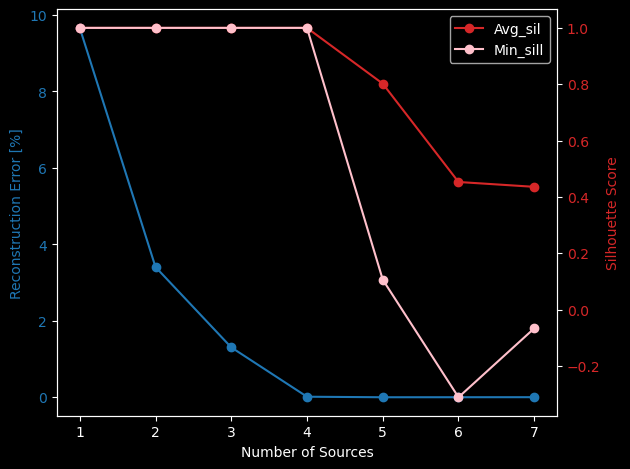

In [14]:
numsources = Forclusts['num_source'].values
avgsilsall    = Forclusts['avg_sillhouette_score'].values
minsillsall   = Forclusts['min_sillhouette_score'].values
recs_all   = Forclusts['reconstruction_loss'].values
plot_results_stability_plot(numsources,avgsilsall,minsillsall,recs_all)

In [15]:
# good_res.groupby('num_sources', group_keys=False).apply(lambda x: result_analysis(x, observations.size))['centers'].iloc[1]

Forclusts['centers'].iloc[4]

array([[ 0.12473557,  0.69991903,  0.38559303,  0.38979156,  0.50006274],
       [-0.12817872,  0.30006231, -0.10364522, -0.24311644,  0.09998255],
       [ 0.24967361,  0.30001035,  0.215059  ,  0.43861195, -0.09998018]])

In [16]:
ground_truth=np.vstack([As,Xs.T])
ground_truth

array([[ 0.4 ,  0.3 ,  0.2 ,  0.5 ,  0.7 ],
       [-0.25, -0.08, -0.15,  0.1 ,  0.3 ],
       [ 0.45,  0.2 ,  0.25, -0.1 ,  0.3 ]])

In [17]:
Forclusts['centers'].iloc[4].round(2)[:,[1,3,0,2,4]]

array([[ 0.7 ,  0.39,  0.12,  0.39,  0.5 ],
       [ 0.3 , -0.24, -0.13, -0.1 ,  0.1 ],
       [ 0.3 ,  0.44,  0.25,  0.22, -0.1 ]])

# jax graph analysis

In [18]:
# # # import tensorflow as tf
# # # from jax.experimental import jax2tf

# # # f_tf = jax2tf.convert(green_matrix)
# # # ff_tf = tf.function(f_tf)

# # # logdir = 'tensorboard-test2/2'
# # # writer = tf.summary.create_file_writer(logdir)
# # # tf.summary.trace_on(graph=True, profiler=True)
# # # ff_tf(As, Xs, Ts, Xd, t, u_scaler, D)
# # # with writer.as_default():
# # #   tf.summary.trace_export(
# # #       name="my_func_trace",
# # #       step=0,
# # #       profiler_outdir=logdir)

# resid = jax.jit(make_flat_resids_fn(model_fn, observations, num_sources))
# flat_init, _ = flatten_inputs(*gen_init(num_sources))
# z=jax.xla_computation(resid)(flat_init)
# graphviz.Source(z.as_hlo_dot_graph())
